# My attempt at making a Lane Emden Eigenvalue problem for the sun   

## $ { \frac{1}{\xi^2}  \frac{d}{d \xi} \biggl( \xi^2 \frac{d \theta}{d \xi} \biggr) } = {- \theta^n}  $  
$ \xi $ is a dimmensionless radius  
$ \theta $ is dimesionless variable relating core density and denity at a point $ \theta^n = \frac{\rho}{\rho_c} $. Thus $ \theta = 0 $ at surface and $ \theta = 1 $ at core.  
Will be using n=3. As this is a good fir for a sun liike star.

### <font color='red'><ins> Within the code i will be using q indtead of theata in the equation to tryand prevent confusion with the coordinate system <ins></font>  

#### Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

#### setting up the compomnents needed for dedalus to understand and solve the equation
This will use n=3 as it is a sun light polytrope

In [2]:
n=3

In [3]:
datatype = np.complex128
coords = d3.SphericalCoordinates("phi" , "theta", "r") #create a set of coordinates
dist = d3.Distributor(coords, dtype = datatype) #assign the coordinates as a distributable and as a complex double.
ball = d3.BallBasis(coords, (1, 1, 50), dtype = datatype,  radius = 1, dealias = 2) # assigning the corrdinates and their extent to a ball

In [4]:
q = dist.Field(name="q", bases=ball) #creating a field as this is what is being solved for
tau = dist.Field(name = "tau", bases=ball.surface) #creating a tau field, this slightly adapts the equation to more solvable one. This is doen by adding boundary conditions.
# There is only a single tau term in trhe radial dimension if a ball as it has inly a single outer edge.
#xi = dist.Field(name = "xi")

In [5]:
lift = lambda A: d3.Lift(A, ball, -1) #Lift puts the tau term in a format thatg works for a ball

creating the problem and adding equations to it. Problem will be created as an eigna value problem for y and tau

The lane emdent equation is effectivly the radial term if a spherical laplacian of theta which equals -theta^n  
$ \nabla^2 \theta = - \theta^n $  
$ \nabla^2 f = \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial f}{\partial r} \right) + \frac{1}{r^2 \sin \theta} \frac{\partial}{\partial \theta} \left( \sin \theta \frac{\partial f}{\partial \theta} \right) + \frac{1}{r^2 \sin^2 \theta} \frac{\partial^2 f}{\partial \phi^2} $  
$ { \frac{1}{\xi^2}  \frac{d}{d \xi} \biggl( \xi^2 \frac{d \theta}{d \xi} \biggr) } = {- \theta^n} $  
$ \xi $ is a dimensionless radius 

In [6]:
problem = d3.NLBVP([q, tau], namespace = locals())
#lap_q = d3.Laplacian(q).evaluate()
#eqn
problem.add_equation("lap(q) + lift(tau) + q**n = 0")
#boundaries
#fx = d3.Differentiate(q, coords['r'])
problem.add_equation("q(r=1) = 0")
#problem.add_equation("grad(q(r=0))= 0")

{'eqn': interp(<Field 140580733361120>, r=1),
 'LHS': interp(<Field 140580733361120>, r=1),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'valid_modes': array([[[ True]]]),
 'F': interp(<Field 140580733361120>, r=1),
 'dF': interp(<Field 140580731619280>, r=1),
 'domain': <dedalus.core.domain.Domain at 0x7fdb8bdcf110>,
 'matrix_dependence': array([False,  True,  True]),
 'matrix_coupling': array([False, False,  True])}

#### Setting the initial conditions

The following cells are code from th eexample code  
https://dedalus-project.readthedocs.io/en/latest/pages/examples/nlbvp_ball_lane_emden.html

In [7]:
phi, theta,r = dist.local_grids(ball)
R0 = 5
q["g"] = ( R0 ** (2/(n-1)) ) * ( 1 - r**2 ) **2

#### Solving

In [8]:
solver = problem.build_solver(ncc_cutoff = 1e-3)
tolerance = 1e-10

#solver.solve
pert_norm = np.inf
q.change_scales(2)
steps = [q['g'].ravel().copy()]
while pert_norm > tolerance:
    solver.newton_iteration()
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')
    q0 = q(r=0).evaluate().allgather_data('g')[0,0,0]
    Ri = q0**((n-1)/2)
    logger.info(f'R iterate: {Ri}')
    steps.append(q['g'].ravel().copy())

2025-06-03 11:56:23,590 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s
2025-06-03 11:56:23,594 __main__ 0/1 INFO :: Perturbation norm: 3.550e-01
2025-06-03 11:56:23,624 __main__ 0/1 INFO :: R iterate: (7.361113662674596+0j)
2025-06-03 11:56:23,693 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s
2025-06-03 11:56:23,696 __main__ 0/1 INFO :: Perturbation norm: 6.203e-02
2025-06-03 11:56:23,698 __main__ 0/1 INFO :: R iterate: (6.927472163516801+0j)
2025-06-03 11:56:23,765 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s
2025-06-03 11:56:23,768 __main__ 0/1 INFO :: Perturbation norm: 1.192e-02
2025-06-03 11:56:23,770 __main__ 0/1 INFO :: R iterate: (6.898414977183625+0j)
2025-06-03 11:56:23,863 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s
2025-06-03 11

In [9]:

# Compare to reference solutions from Boyd
R_ref = {0.0: np.sqrt(6),
        0.5: 2.752698054065,
        1.0: np.pi,
        1.5: 3.65375373621912608,
        2.0: 4.3528745959461246769735700,
        2.5: 5.355275459010779,
        3.0: 6.896848619376960375454528,
        3.25: 8.018937527,
        3.5: 9.535805344244850444,
        4.0: 14.971546348838095097611066,
        4.5: 31.836463244694285264}
logger.info('-'*20)
logger.info(f'Iterations: {solver.iteration}')
logger.info(f'Final R iteration: {Ri}')
if n in R_ref:
    logger.info(f'Error vs reference: {Ri-R_ref[n]:.3e}')


2025-06-03 11:56:24,046 __main__ 0/1 INFO :: --------------------
2025-06-03 11:56:24,048 __main__ 0/1 INFO :: Iterations: 6
2025-06-03 11:56:24,050 __main__ 0/1 INFO :: Final R iteration: (6.896848619377109+0j)
2025-06-03 11:56:24,051 __main__ 0/1 INFO :: Error vs reference: 1.483e-13+0.000e+00j


/home/ben2121/miniforge3/envs/dedalus3/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ben2121/miniforge3/envs/dedalus3/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


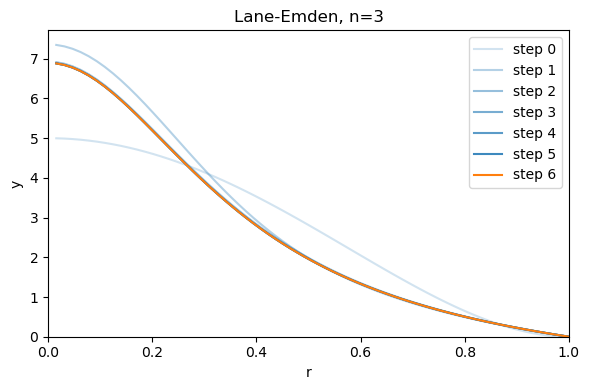

In [12]:
plt.figure(figsize=(6, 4))
_, _, r = dist.local_grids(ball, scales=(2,2,2))
alpha = np.linspace(0.2, 1, len(steps))
color = ('C0',) * (len(steps)-1) + ('C1',)
for i, step in enumerate(steps):
    plt.plot(r.ravel(), step, c=color[i], alpha=alpha[i], label=f"step {i}")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, None)
plt.xlabel('r')
plt.ylabel('y')
plt.title(f"Lane-Emden, n={n}")
plt.tight_layout()
plt.savefig('lane_emden example and my code code.pdf')
plt.savefig('lane_emden example and my code code.png', dpi=200)

# Parameters
Nr = 64
n = 3.0
ncc_cutoff = 1e-3
tolerance = 1e-10
dealias = 2
dtype = np.complex128

# Bases
coords = d3.SphericalCoordinates('phi', 'theta', 'r')
dist = d3.Distributor(coords, dtype=dtype)
ball = d3.BallBasis(coords, (1, 1, 100), radius=1, dtype=dtype, dealias=dealias)

# Fields
q = dist.Field(name='q', bases=ball)
tau = dist.Field(name='tau', bases=ball.surface)

# Substitutions
lift = lambda A: d3.Lift(A, ball, -1)

# Problem
problem = d3.NLBVP([q, tau], namespace=locals())
problem.add_equation("lap(q) + lift(tau) = - q**n")
problem.add_equation("q(r=0) = 1")


The 3d polytropic lane emden  

$q_{xx} = \frac{d^2 q}{d x^2} and $ $q_{x} = \frac{d q}{d x} $  
$ q_{rr} + \bigl( \frac{2}{r} \bigr) q_r + y^m = 0 $ with $ q(0) = 1 $ and $ q_r(0) = 0 $   Which when $ r = \xi x $ is applied it becomes $ q_{xx} + \bigl( \frac{2}{x} \bigr) q_r + { \xi^2 q^m} = 0 $
as stated by   
@article{article,
author = {Boyd, John},
year = {2011},
month = {05},
pages = {},
title = {Chebyshev Spectral Methods and the Lane-Emden Problem},
volume = {4},
journal = {Numerical Mathematics: Theory, Methods and Applications},
doi = {10.4208/nmtma.2011.42s.2}
}